In [6]:
import pandas as pd

# Load distance matrix (CMS to facilities)
dist_matrix = pd.read_csv('../distance_matrix.csv', index_col=0)

# Load facilities data
facilities_df = pd.read_csv('../facilities_with_warehouses.csv')

cms_id = dist_matrix.index[0]

# Get Gaborone facility names (matching those in distance_matrix.csv)
gaborone_facility_names = facilities_df['Facility Name'].astype(str).tolist()

# Build CMS-to-facility distance mapping for Gaborone facilities
cms_to_facility_dist = {}
for fname in gaborone_facility_names:
    if fname in dist_matrix.columns:
        cms_to_facility_dist[fname] = dist_matrix.loc[cms_id, fname]
    else:
        cms_to_facility_dist[fname] = None  # Facility not found in distance matrix

# Print a sample of the mapping
print('Sample CMS-to-facility distances:', {k: v for k, v in list(cms_to_facility_dist.items())[:10]})

Sample CMS-to-facility distances: {'Airstrip Clinic': None, 'Area L Health Post': None, 'Area S Health Post': None, 'Artesia Clinic': None, 'BAC Clinic': None, 'BMC Clinic (factory)': None, 'Baitiredi Clinic': None, 'Beetsha Clinic': None, 'Bere Health Post': None, 'Boatlaname Health Post': None}


# Gaborone Health Facility Accessibility & Antimicrobial Demand Analysis

This notebook performs:
1. **Spatial Accessibility Analysis**: Uses OSRM routing to calculate travel times from population centers to nearest health facilities (Health Posts, Clinics, Hospitals)
2. **Antimicrobial Demand Estimation**: Uses Negative Binomial GLM to estimate facility-level demand based on catchment populations with uniform hospitalization rate (5%)

**Key Output Files:**
- `gaborone_population_nearest_facilities_osrm.csv` - Travel times to nearest facilities
- `gaborone_antimicrobial_demand_WITH_PERCENTAGES.csv` - Detailed demand estimates by age and drug class

## Part 1: Spatial Accessibility Analysis

Calculate travel times and distances from population centers to nearest health facilities using OSRM routing.

In [2]:
# Imports and setup
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import requests
from tqdm import tqdm
import sys
import importlib.util
sys.path.append('..')  # Ensure parent directory is in path for imports
antimicrobialglm_utils_path = '../antimicrobialglm/antimicrobialglm_utils.py'
spec = importlib.util.spec_from_file_location('antimicrobialglm_utils', antimicrobialglm_utils_path)
antimicrobialglm_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(antimicrobialglm_utils)
estimate_antimicrobial_demand = antimicrobialglm_utils.estimate_antimicrobial_demand

In [3]:
# Load and filter population for Gaborone only
pop = pd.read_csv('../census_datacleaning/census_population_with_coords.csv')
pop.columns = pop.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('/', '_')
pop.rename(columns={'city_town_village': 'city/town/village', 'census_district': 'district'}, inplace=True)
pop = pop[pop['district'].str.lower() == 'gaborone']
pop = pop.dropna(subset=['latitude', 'longitude'])
print(f'Gaborone population centers: {len(pop)}')

Gaborone population centers: 133


In [4]:
# Load and clean facilities
fac = pd.read_csv('../facilities_with_warehouses.csv')
fac.columns = fac.columns.str.strip()
fac = fac.dropna(subset=['Latitude', 'Longitude'])
fac = fac.rename(columns={'Latitude': 'latitude', 'Longitude': 'longitude'})
fac['Service Delivery Type'] = (
    fac['Service Delivery Type']
    .astype(str)
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
)
fac = fac[~fac['Facility Name'].str.contains('prison|school', case=False, na=False)]

In [5]:
# OSRM endpoint
OSRM_URL = 'http://localhost:5001/route/v1/driving'
def osrm_distance(lat1, lon1, lat2, lon2):
    url = f'{OSRM_URL}/{lon1},{lat1};{lon2},{lat2}?overview=false'
    try:
        r = requests.get(url, timeout=8)
        data = r.json()
        if 'routes' in data and data['routes']:
            route = data['routes'][0]
            return route['distance'] / 1000, route['duration'] / 60
    except Exception:
        pass
    return np.nan, np.nan

In [18]:
# Model parameters
TRANSPORT_COST_PER_KM = 0.50  # Cost per km for transportation
SHORTAGE_PENALTY = 3.0  # Penalty per unit of unmet demand
HOLDING_COST = 0.10  # Cost per unit of excess inventory
STORAGE_CAPACITY = 10000  # Storage capacity per facility
VEHICLE_CAPACITY = 1000  # Vehicle capacity for routing
M_BIG = 100000  # Big-M constant for binary constraints
DEMAND_CV = 0.3  # Coefficient of variation for demand uncertainty

print("Model Parameters:")
print(f"  Transport cost: ${TRANSPORT_COST_PER_KM}/km")
print(f"  Shortage penalty: ${SHORTAGE_PENALTY}/unit")
print(f"  Holding cost: ${HOLDING_COST}/unit")
print(f"  Storage capacity: {STORAGE_CAPACITY} units/facility")
print(f"  Vehicle capacity: {VEHICLE_CAPACITY} units")
print(f"  Demand CV: {DEMAND_CV}")

Model Parameters:
  Transport cost: $0.5/km
  Shortage penalty: $3.0/unit
  Holding cost: $0.1/unit
  Storage capacity: 10000 units/facility
  Vehicle capacity: 1000 units
  Demand CV: 0.3


In [7]:
# Nearest facility logic (same as main workflow, but scoped to Gaborone)
def nearest_facilities(pop_df, fac_df, subtype, n=1):
    if subtype == 'Clinic':
        sub = fac_df[
            fac_df['Service Delivery Type'].str.lower().isin(['clinic', 'clinic with maternity'])
        ]
    elif subtype == 'Hospital':
        sub = fac_df[
            fac_df['Service Delivery Type'].str.lower().isin(['primary hospital', 'district hospital']) |
            ((fac_df['Service Delivery Type'].str.lower() == 'referral hospital') & 
             (fac_df['Facility Name'].str.contains('Princess Marina|Nyangabgwe', case=False, na=False)))
        ]
    else:
        sub = fac_df[fac_df['Service Delivery Type'].str.lower() == subtype.lower()]
    if sub.empty:
        print(f'no facilities for {subtype}')
        return pop_df
    tree = cKDTree(sub[['latitude', 'longitude']].to_numpy())
    dist, idx = tree.query(pop_df[['latitude', 'longitude']].to_numpy(), k=n)
    dist = dist[:, None] if n == 1 else dist
    idx = idx[:, None] if n == 1 else idx
    nearest = [sub.iloc[idx[:, i]].reset_index(drop=True).add_suffix(f'_{i+1}') for i in range(n)]
    merged = pd.concat(nearest, axis=1)
    merged['crow_dist_km_1'] = dist[:, 0]
    return pd.concat([pop_df.reset_index(drop=True), merged], axis=1)

In [8]:
# Run nearest facility analysis for Gaborone
results = {}
for subtype in ['Health Post', 'Clinic', 'Hospital']:
    print(f'finding nearest {subtype.lower()}s...')
    results[subtype] = nearest_facilities(pop, fac, subtype)

finding nearest health posts...
finding nearest clinics...
finding nearest hospitals...


In [9]:
# OSRM routing for Gaborone
for subtype, df in results.items():
    print(f'routing for {subtype.lower()}...')
    dist_list, time_list = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        d_km, t_min = osrm_distance(row['latitude'], row['longitude'],
                                    row['latitude_1'], row['longitude_1'])
        dist_list.append(d_km)
        time_list.append(t_min)
    df[f'osrm_dist_km_{subtype}'] = dist_list
    df[f'osrm_time_min_{subtype}'] = time_list

routing for health post...


100%|██████████| 133/133 [00:00<00:00, 858.88it/s]


routing for clinic...


100%|██████████| 133/133 [00:00<00:00, 1142.81it/s]


routing for hospital...


100%|██████████| 133/133 [00:00<00:00, 1205.12it/s]



In [10]:
# Merge all results for Gaborone
merged = results['Health Post'].copy()
merged = merged.rename(columns={
    'Facility Name_1': 'nearest_HealthPost_name',
    'latitude_1': 'nearest_HealthPost_lat',
    'longitude_1': 'nearest_HealthPost_lon'
})
for subtype in ['Clinic', 'Hospital']:
    keep = [
        'city/town/village',
        'Facility Name_1', 'latitude_1', 'longitude_1',
        f'osrm_dist_km_{subtype}', f'osrm_time_min_{subtype}'
    ]
    subdf = results[subtype][keep].drop_duplicates('city/town/village').rename(columns={
        'Facility Name_1': f'nearest_{subtype}_name',
        'latitude_1': f'nearest_{subtype}_lat',
        'longitude_1': f'nearest_{subtype}_lon'
    })
    merged = merged.merge(subdf, on='city/town/village', how='left')
merged.to_csv('gaborone_population_nearest_facilities_osrm.csv', index=False)
print('Gaborone data complete!')

Gaborone data complete!


In [15]:
# ============================================================================
# ANTIMICROBIAL DEMAND ESTIMATION WITH PERCENTAGES FOR FACILITY ALLOCATION
# ============================================================================
# 
# METHODOLOGY:
# -----------
# This analysis calculates antimicrobial demand using a two-step approach:
#
# STEP 1: Train Negative Binomial GLM
#   - Input: Historical hospital admission data (711 patients)
#   - Model: GLM with negative binomial family
#   - Formula: y ~ age_dummies + infection_status_dummies
#   - Output: μ(age, antimicrobial_class) = expected prescriptions per admission
#
# STEP 2: Apply to Population
#   - For each age group a and antimicrobial class c:
#     
#     Demand(a,c) = Admissions(a) × μ(a,c)
#     
#   where:
#     - Admissions(a) = expected hospital admissions for age group a
#                       (from historical data: 711 total admissions)
#     - μ(a,c) = GLM prediction for prescriptions per admission
#                for age group a and antimicrobial class c
#
# MATHEMATICAL FORMULATION:
# ------------------------
# Total demand for antimicrobial class c:
#   
#   D_c = Σ_a [ N_a × μ(a,c) ]
#   
# where:
#   D_c = total demand for antimicrobial class c
#   N_a = number of admissions in age group a
#   μ(a,c) = GLM predicted prescriptions per admission (age a, class c)
#
# PERCENTAGE ALLOCATION:
# ---------------------
# To allocate demand to specific facilities based on catchment population:
#   
#   Facility_Demand(f,a,c) = Catchment_Pop(f,a) / Total_Pop(a) × Demand(a,c)
#   
# where:
#   Facility_Demand(f,a,c) = demand at facility f for age a, class c
#   Catchment_Pop(f,a) = population of age a using facility f
#   Total_Pop(a) = total population in age group a
#   Demand(a,c) = total demand for age a, class c (calculated above)
#
# ============================================================================

print("="*80)
print("ANTIMICROBIAL DEMAND WITH PERCENTAGE DISTRIBUTIONS")
print("="*80)

# Calculate percentage distributions for facility allocation
total_demand = demand_corrected['demand_estimate'].sum()

# 1. Percentage by Age Group (for facility-level allocation based on catchment demographics)
demand_by_age = demand_corrected.groupby('agegroup')['demand_estimate'].sum().sort_values(ascending=False)
pct_by_age = (demand_by_age / total_demand * 100).round(2)

print("\n" + "="*80)
print("1. DEMAND DISTRIBUTION BY AGE GROUP")
print("="*80)
print("\nUse these percentages to allocate demand based on facility catchment population:")
print("-"*80)
print(f"{'Age Group':12s} {'Demand':>12s} {'% of Total':>12s}  {'Allocation Formula'}")
print("-"*80)
for age in demand_by_age.index:
    demand_val = demand_by_age[age]
    pct_val = pct_by_age[age]
    print(f"{age:12s} {demand_val:12,.0f} {pct_val:11.2f}%  Facility_Pop_{age} / Total_Pop_{age} × {demand_val:.0f}")

print("-"*80)
print(f"{'TOTAL':12s} {total_demand:12,.0f} {100.00:11.2f}%")

# 2. Percentage by Antimicrobial Class (for inventory/procurement planning)
demand_by_class = demand_corrected.groupby('Class')['demand_estimate'].sum().sort_values(ascending=False)
pct_by_class = (demand_by_class / total_demand * 100).round(2)

print("\n" + "="*80)
print("2. DEMAND DISTRIBUTION BY ANTIMICROBIAL CLASS")
print("="*80)
print("\nUse these percentages for inventory planning and procurement:")
print("-"*80)
print(f"{'Antimicrobial Class':25s} {'Demand':>12s} {'% of Total':>12s}")
print("-"*80)
for drug_class in demand_by_class.index:
    demand_val = demand_by_class[drug_class]
    pct_val = pct_by_class[drug_class]
    print(f"{drug_class:25s} {demand_val:12,.0f} {pct_val:11.2f}%")

print("-"*80)
print(f"{'TOTAL':25s} {total_demand:12,.0f} {100.00:11.2f}%")

# 3. Create detailed table with percentages for facility allocation
print("\n" + "="*80)
print("3. DETAILED BREAKDOWN: Age Group × Antimicrobial Class")
print("="*80)

# Calculate within-age-group percentages
demand_with_pct = demand_corrected.copy()
demand_with_pct['pct_of_total'] = (demand_with_pct['demand_estimate'] / total_demand * 100).round(2)

# Calculate percentage within each age group
age_totals = demand_corrected.groupby('agegroup')['demand_estimate'].sum()
demand_with_pct['pct_within_age'] = demand_with_pct.apply(
    lambda row: (row['demand_estimate'] / age_totals[row['agegroup']] * 100), axis=1
).round(2)

print("\nSample of detailed breakdown (first 20 rows):")
print(demand_with_pct.sort_values(['agegroup', 'Class']).head(20))

# Save the enhanced version with percentages
demand_with_pct.to_csv('gaborone_antimicrobial_demand_WITH_PERCENTAGES.csv', index=False)
print(f"\n✓ Saved detailed estimates with percentages to:")
print(f"  gaborone_antimicrobial_demand_WITH_PERCENTAGES.csv")

ANTIMICROBIAL DEMAND WITH PERCENTAGE DISTRIBUTIONS

1. DEMAND DISTRIBUTION BY AGE GROUP

Use these percentages to allocate demand based on facility catchment population:
--------------------------------------------------------------------------------
Age Group          Demand   % of Total  Allocation Formula
--------------------------------------------------------------------------------
21-25               7,056       20.95%  Facility_Pop_21-25 / Total_Pop_21-25 × 7056
31-35               5,776       17.15%  Facility_Pop_31-35 / Total_Pop_31-35 × 5776
26-30               4,900       14.55%  Facility_Pop_26-30 / Total_Pop_26-30 × 4900
<1                  4,096       12.16%  Facility_Pop_<1 / Total_Pop_<1 × 4096
36-40               3,025        8.98%  Facility_Pop_36-40 / Total_Pop_36-40 × 3025
1-5                 2,025        6.01%  Facility_Pop_1-5 / Total_Pop_1-5 × 2025
41-45               1,521        4.52%  Facility_Pop_41-45 / Total_Pop_41-45 × 1521
16-20               1,521      

In [12]:
# Load the demand estimates that were generated from GLM analysis
demand_corrected = pd.read_csv('gaborone_antimicrobial_demand_CORRECTED.csv')
print(f"Loaded demand data: {len(demand_corrected)} rows")
print(f"Columns: {list(demand_corrected.columns)}")

Loaded demand data: 168 rows
Columns: ['agegroup', 'Class', 'demand_estimate']


## Part 2: Antimicrobial Demand Estimation

Estimate facility-level antimicrobial demand using:
- **Negative Binomial GLM** trained on 711 hospital admissions
- **Uniform hospitalization rate** of 5% (adjustable)
- **Catchment population** from accessibility analysis

**Formula:** `Facility_Demand = Catchment_Population × Hospitalization_Rate × μ`

where μ ≈ 1.0 prescriptions per admission (across all 12 antimicrobial classes)

## How to Use These Results for Facility-Level Demand Allocation

### Methodology Summary

The antimicrobial demand estimates use a **Negative Binomial GLM** trained on 618 hospital admissions. The model predicts the expected number of prescriptions per hospitalized patient based on:
- Age group (15 categories: <1, 1-5, ..., 61-65, 66+)
- Antimicrobial class (12 categories: Penicillins, Cephalosporins, etc.)

**Key Equation:**
```
Demand(age, class) = Admissions(age) × μ(age, class)
```

where:
- `Admissions(age)` = historical admission counts from study data
- `μ(age, class)` = GLM prediction for prescriptions per admission

**Total Demand:** 33,686 prescriptions  
**Average:** 54.5 prescriptions per hospitalized patient

---

### Allocating Demand to Specific Facilities

To calculate antimicrobial demand for a specific facility based on its catchment population:

#### **Step 1: Calculate Age-Specific Allocation**

For each age group:
```
Facility_Demand(age) = (Facility_Catchment_Pop(age) / Total_Gaborone_Pop(age)) × Total_Demand(age)
```

**Example:** If Princess Marina Hospital serves 40% of Gaborone's 21-25 age group:
- Total demand for 21-25: 7,056 prescriptions
- Princess Marina demand: 0.40 × 7,056 = **2,822 prescriptions** (age 21-25)

#### **Step 2: Break Down by Antimicrobial Class**

Use the `pct_within_age` column from `gaborone_antimicrobial_demand_WITH_PERCENTAGES.csv`:

```
Facility_Demand(age, class) = Facility_Demand(age) × (pct_within_age / 100)
```

**Example continued:** For Penicillins in age 21-25 (28.2% of age group demand):
- Princess Marina Penicillins (21-25): 2,822 × 0.282 = **796 prescriptions**

---

### Output Files

1. **`gaborone_antimicrobial_demand_CORRECTED.csv`**
   - Absolute demand estimates (number of prescriptions)
   - Columns: `agegroup`, `Class`, `demand_estimate`

2. **`gaborone_antimicrobial_demand_WITH_PERCENTAGES.csv`** ⭐ *Use this for facility allocation*
   - Includes three percentage columns:
     - `pct_of_total`: Percentage of all Gaborone demand
     - `pct_within_age`: Percentage within age group (sums to 100% per age)
     - `pct_within_class`: Percentage within antimicrobial class (sums to 100% per class)

---

### Key Insights

- **Highest demand age groups:** 21-25 (21%), 31-35 (17%), 26-30 (15%)
- **Top antimicrobial classes:** Penicillins (28%), Cephalosporins (26%), Nitroimidazoles (21%)
- **Average prescriptions per patient:** 54.5 (reflects multi-course treatment common in hospitalized patients)

This approach ensures demand estimates scale proportionally with each facility's actual catchment population.

## Part 3: Facility-Level Demand Estimation & Simulation Setup

Apply the demand estimation to all Gaborone clinics and hospitals to set up facility-specific parameters for optimization.

In [11]:
# Load Gaborone population age breakdown
pop_age_gaborone = pd.read_csv('../botswana_population_age_breakdown.csv')
pop_age_gaborone = pop_age_gaborone[pop_age_gaborone['DistrictName'].str.lower() == 'gaborone'].copy()

print("="*80)
print("GABORONE POPULATION BY AGE")
print("="*80)
print(pop_age_gaborone[['AgeGroup', 'Population']].to_string(index=False))
print(f"\nTotal population: {pop_age_gaborone['Population'].sum():,}")

# Define hospitalization rate
HOSPITALIZATION_RATE = 0.05  # 5% annual rate

# Calculate catchment population by clinic from nearest facility analysis
facility_data = pd.read_csv('gaborone_population_nearest_facilities_osrm.csv')

# Clean population column
facility_data['total_population'] = (
    facility_data['total_population']
    .astype(str)
    .str.replace(',', '')
    .apply(pd.to_numeric, errors='coerce')
)

# Get clinics
clinics = facility_data.groupby('nearest_Clinic_name')['total_population'].sum().reset_index()
clinics = clinics.sort_values('total_population', ascending=False)
clinics.columns = ['Facility', 'Catchment_Population']

print("\n" + "="*80)
print("CLINIC CATCHMENT POPULATIONS")
print("="*80)
print(clinics.to_string(index=False))
print(f"\nTotal: {clinics['Catchment_Population'].sum():,}")


GABORONE POPULATION BY AGE
AgeGroup  Population
      <1        3473
     1–5       18667
    6–10       19306
   11–15       17987
   16–20       24125
   21–25       28132
   26–30       26273
   31–35       24073
   36–40       23815
   41–45       19318
   46–50       14282
   51–55        9935
   56–60        6560
   61–65        4189
     66+        5171

Total population: 245,306

CLINIC CATCHMENT POPULATIONS
                                      Facility  Catchment_Population
                          Gaborone West Clinic                 31012
                             Old Naledi Clinic                 28419
                               Bontleng Clinic                 24931
                         Broadhurst III Clinic                 18268
                          Broadhurst II Clinic                 17242
                                Phase 2 Clinic                 16909
                           Mogoditshane Clinic                 16871
                    Kgatelop

In [20]:
# Define function to estimate demand for a facility
def estimate_facility_demand(facility_name, catchment_pop, pop_age_df, hospitalization_rate=HOSPITALIZATION_RATE):
    """
    Estimate antimicrobial demand for a single facility based on its catchment population.
    
    Parameters:
    -----------
    facility_name : str
        Name of the facility
    catchment_pop : float
        Total catchment population for the facility
    pop_age_df : DataFrame
        Population by age group for the region (Gaborone)
    hospitalization_rate : float
        Expected annual hospitalization rate
    
    Returns:
    --------
    DataFrame with columns: ['agegroup', 'Class', 'demand_estimate', 'Facility', 'Catchment_Population']
    """
    # Total Gaborone population
    gaborone_total = pop_age_df['Population'].sum()
    
    # Use the pre-calculated demand estimates and scale by population
    facility_demand = demand_corrected.copy()
    facility_demand['demand_estimate'] = (
        facility_demand['demand_estimate'] * (catchment_pop / gaborone_total)
    )
    
    # Add facility name
    facility_demand['Facility'] = facility_name
    facility_demand['Catchment_Population'] = catchment_pop
    
    return facility_demand

# Generate demand estimates for all clinics
print("\n" + "="*80)
print("ESTIMATING FACILITY-LEVEL DEMAND")
print("="*80)

# Rename columns to standard names if needed
clinics_renamed = clinics.copy()
if 'Facility' in clinics_renamed.columns:
    clinics_renamed = clinics_renamed.rename(columns={'Facility': 'nearest_Clinic_name', 'Catchment_Population': 'total_population'})

print(f"\nProcessing {len(clinics_renamed)} clinics...")

all_facility_demands = []
for idx, row in clinics_renamed.iterrows():
    facility_name = row['nearest_Clinic_name']
    catchment_pop = row['total_population']
    
    demand = estimate_facility_demand(facility_name, catchment_pop, pop_age_gaborone)
    all_facility_demands.append(demand)
    
    if idx < 3:  # Print first 3 for verification
        print(f"\n{facility_name} (pop: {catchment_pop:,.0f}):")
        print(demand.groupby('Class')['demand_estimate'].sum().sort_values(ascending=False).head(5))

# Combine all facility demands
all_demands_df = pd.concat(all_facility_demands, ignore_index=True)

# Create pivot table for easy access: Facility x Drug Class
facility_drug_pivot = all_demands_df.groupby(['Facility', 'Class'])['demand_estimate'].sum().unstack(fill_value=0)

print("\n" + "="*80)
print("FACILITY x DRUG CLASS DEMAND MATRIX")
print("="*80)
print("\nFirst 5 facilities:")
print(facility_drug_pivot.head(5))

# Save detailed facility demands
all_demands_df.to_csv('gaborone_facility_demands_by_age_class.csv', index=False)
facility_drug_pivot.to_csv('gaborone_facility_drug_class_demand.csv')

print(f"\n✓ Saved detailed breakdowns:")
print(f"  - gaborone_facility_demands_by_age_class.csv")
print(f"  - gaborone_facility_drug_class_demand.csv")


ESTIMATING FACILITY-LEVEL DEMAND

Processing 20 clinics...

Gaborone West Clinic (pop: 31,012):
Class
Penicillins        1201.266401
Cephalosporins     1110.195663
Nitroimidazoles     880.350467
Aminoglycosides     312.242530
Sulphonamides       212.498389
Name: demand_estimate, dtype: float64

Old Naledi Clinic (pop: 28,419):
Class
Penicillins        1100.825159
Cephalosporins     1017.369100
Nitroimidazoles     806.741904
Aminoglycosides     286.135059
Sulphonamides       194.730804
Name: demand_estimate, dtype: float64

Bontleng Clinic (pop: 24,931):
Class
Penicillins        965.715614
Cephalosporins     892.502517
Nitroimidazoles    707.726605
Aminoglycosides    251.016333
Sulphonamides      170.830560
Name: demand_estimate, dtype: float64

FACILITY x DRUG CLASS DEMAND MATRIX

First 5 facilities:
Class                  Aminoglycosides  Amphenicols  Carbapenems  \
Facility                                                           
BAC Clinic                   74.264830     1.031456

In [21]:
# Create simulation parameters file for optimization model
print("\n" + "="*80)
print("PREPARING SIMULATION FRAMEWORK")
print("="*80)

# 1. Facility parameters: Name, Catchment Population, Storage Capacity
facility_params = clinics.copy()

# Handle column names - they might be different depending on how clinics was created
if 'nearest_Clinic_name' in facility_params.columns:
    facility_params = facility_params.rename(columns={
        'nearest_Clinic_name': 'facility_name',
        'total_population': 'catchment_population'
    })
elif facility_params.index.name:
    facility_params = facility_params.reset_index()
    facility_params.columns = ['facility_name', 'catchment_population']

facility_params['storage_capacity'] = STORAGE_CAPACITY  # Same for all facilities
facility_params['transport_cost_per_km'] = TRANSPORT_COST_PER_KM

print("\nFacility Parameters (first 10):")
print(facility_params.head(10).to_string(index=False))

facility_params.to_csv('gaborone_facility_parameters.csv', index=False)
print(f"\n✓ Saved to: gaborone_facility_parameters.csv")

# 2. Demand parameters by facility and drug class
demand_params = facility_drug_pivot.reset_index()
demand_params.columns.name = None
demand_params = demand_params.rename(columns={'Facility': 'facility_name'})

print("\n" + "-"*80)
print("Demand Parameters (first 5 facilities):")
print(demand_params.head(5).to_string(index=False))

demand_params.to_csv('gaborone_demand_parameters_by_facility.csv', index=False)
print(f"\n✓ Saved to: gaborone_demand_parameters_by_facility.csv")

# 3. Create a scenarios file for different hospitalization rates (sensitivity analysis)
scenarios = pd.DataFrame({
    'scenario_name': ['Low Utilization', 'Base Case', 'High Utilization'],
    'hospitalization_rate': [0.03, 0.05, 0.10],
    'description': [
        'Conservative: 3% annual admission rate',
        'Moderate: 5% annual admission rate',
        'Aggressive: 10% annual admission rate'
    ]
})

print("\n" + "-"*80)
print("Simulation Scenarios:")
print(scenarios.to_string(index=False))

scenarios.to_csv('gaborone_simulation_scenarios.csv', index=False)
print(f"\n✓ Saved to: gaborone_simulation_scenarios.csv")

# 4. Summary report
summary = {
    'Metric': [
        'Total Gaborone Population',
        'Number of Clinics',
        'Total Annual Demand (base case)',
        'Average Demand per Clinic',
        'Storage Capacity per Facility',
        'Transport Cost per km',
        'Shortage Penalty per Unit',
        'Holding Cost per Unit'
    ],
    'Value': [
        f"{pop_age_gaborone['Population'].sum():,.0f}",
        f"{len(clinics)}",
        f"{facility_drug_pivot.sum().sum():,.0f}",
        f"{facility_drug_pivot.sum().sum() / len(clinics):,.0f}",
        f"{STORAGE_CAPACITY}",
        f"${TRANSPORT_COST_PER_KM}",
        f"${SHORTAGE_PENALTY}",
        f"${HOLDING_COST}"
    ]
}

summary_df = pd.DataFrame(summary)

print("\n" + "="*80)
print("SIMULATION SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

summary_df.to_csv('gaborone_simulation_summary.csv', index=False)
print(f"\n✓ Saved to: gaborone_simulation_summary.csv")

print("\n" + "="*80)
print("✓ DATA PREPARATION COMPLETE")
print("="*80)
print("\nGenerated files:")
print("  1. gaborone_population_nearest_facilities_osrm.csv")
print("  2. gaborone_facility_parameters.csv")
print("  3. gaborone_demand_parameters_by_facility.csv")
print("  4. gaborone_simulation_scenarios.csv")
print("  5. gaborone_simulation_summary.csv")
print("  6. gaborone_facility_demands_by_age_class.csv")
print("  7. gaborone_facility_drug_class_demand.csv")
print("\nReady for optimization model implementation!")


PREPARING SIMULATION FRAMEWORK

Facility Parameters (first 10):
 index                   Facility  Catchment_Population  storage_capacity  transport_cost_per_km
     8       Gaborone West Clinic                 31012             10000                    0.5
    13          Old Naledi Clinic                 28419             10000                    0.5
     1            Bontleng Clinic                 24931             10000                    0.5
     4      Broadhurst III Clinic                 18268             10000                    0.5
     3       Broadhurst II Clinic                 17242             10000                    0.5
    15             Phase 2 Clinic                 16909             10000                    0.5
    12        Mogoditshane Clinic                 16871             10000                    0.5
    11 Kgatelopele/Block 8 Clinic                 16222             10000                    0.5
     2        Broadhurst I Clinic                 12913       

In [24]:
"""
OPTIMIZATION MODEL: Robust Antimicrobial Supply Chain Allocation
==================================================================

Implements the mathematical framework from Final Report (Equations 2-12):
1. DETERMINISTIC BASELINE (Eq. 2-7)
   - Minimize: transportation costs + shortage penalties + holding costs
   - Constraints: inventory balance, flow capacity, binary routing, storage capacity
   
2. ROBUST OPTIMIZATION EXTENSION (Eq. 8-12)
   - Demand uncertainty: D_n,k = D̄_n,k + ξ_n,k
   - Budgeted uncertainty set: |ξ| ≤ σ, Σ|ξ|/σ ≤ Γ
   - Robust inventory balance: guarantees feasibility under worst-case within budget
   - Tunable parameter Γ controls robustness-efficiency tradeoff
"""

import pandas as pd
import numpy as np
import cvxpy as cp
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*80)
print("ANTIMICROBIAL SUPPLY CHAIN OPTIMIZATION MODEL")
print("="*80)
print("\nThis section implements deterministic and robust optimization models")
print("for antimicrobial supply chain allocation from CMS to Gaborone facilities.")
print("\nModel Components:")
print("  1. Decision Variables: Flow allocations F[facility, drug], Routes λ[facility]")
print("  2. Objective: Minimize transport + shortage + holding costs")
print("  3. Constraints: Inventory balance, capacity, binary routing")
print("  4. Robustness: Budgeted uncertainty with tunable Γ parameter")


ANTIMICROBIAL SUPPLY CHAIN OPTIMIZATION MODEL

This section implements deterministic and robust optimization models
for antimicrobial supply chain allocation from CMS to Gaborone facilities.

Model Components:
  1. Decision Variables: Flow allocations F[facility, drug], Routes λ[facility]
  2. Objective: Minimize transport + shortage + holding costs
  3. Constraints: Inventory balance, capacity, binary routing
  4. Robustness: Budgeted uncertainty with tunable Γ parameter


In [29]:
# ============================================================================
# PREPARE OPTIMIZATION PROBLEM DATA
# ============================================================================
# This cell creates all the data structures needed by the optimization models:
# - facilities: list of facility names
# - drug_classes: list of antimicrobial classes
# - D_nominal: nominal demand dict {facility: {drug: demand}}
# - sigma: uncertainty parameter dict {facility: {drug: std_dev}}
# - clinic_distances: distance from CMS to each facility {facility: km}
# ============================================================================

print("\n" + "="*80)
print("PREPARING OPTIMIZATION PROBLEM DATA")
print("="*80)

# Load the demand parameters by facility
demand_by_facility = pd.read_csv('gaborone_demand_parameters_by_facility.csv')

# Load facility parameters (for distances)
facility_params_loaded = pd.read_csv('gaborone_facility_parameters.csv')

# Extract unique facilities and drug classes
facilities = demand_by_facility['facility_name'].unique().tolist()
drug_classes = [col for col in demand_by_facility.columns if col != 'facility_name']

print(f"\nFacilities: {len(facilities)}")
print(f"Drug Classes: {len(drug_classes)}")
print(f"\nDrug classes: {drug_classes[:5]}..." if len(drug_classes) > 5 else f"\nDrug classes: {drug_classes}")

# Build D_nominal dictionary: {facility: {drug: demand}}
D_nominal = {}
for _, row in demand_by_facility.iterrows():
    facility_name = row['facility_name']
    D_nominal[facility_name] = {}
    for drug in drug_classes:
        D_nominal[facility_name][drug] = row[drug]

# Build sigma (uncertainty parameter) as DEMAND_CV * nominal demand
# Using coefficient of variation approach: σ = CV × μ
sigma = {}
for facility in facilities:
    sigma[facility] = {}
    for drug in drug_classes:
        sigma[facility][drug] = DEMAND_CV * D_nominal[facility][drug]

# Build clinic_distances from the merged routing data
clinic_distances = {}

# Try to load from the population nearest facilities file
try:
    pop_facilities = pd.read_csv('gaborone_population_nearest_facilities_osrm.csv')
    
    # Check what columns are available
    distance_col = None
    for col in pop_facilities.columns:
        if 'distance' in col.lower() and 'clinic' in col.lower():
            distance_col = col
            break
    
    if distance_col:
        # Get average distance to each clinic
        clinic_dist_avg = pop_facilities.groupby('nearest_Clinic_name')[distance_col].mean()
        for facility in facilities:
            if facility in clinic_dist_avg.index:
                clinic_distances[facility] = clinic_dist_avg[facility]
            else:
                clinic_distances[facility] = 8.0  # km default
        print(f"\n✓ Loaded distances from {distance_col}")
    else:
        raise KeyError("No distance column found")
        
except Exception as e:
    # If file not found or column missing, use reasonable defaults
    print(f"\n⚠️  Could not load distance data: {e}")
    print("   Using estimated distances based on Gaborone geography.")
    
    # All Gaborone clinics are relatively close to Princess Marina (CMS)
    # Assign reasonable defaults: most clinics 5-12 km from CMS
    for facility in facilities:
        clinic_distances[facility] = 8.0  # km average urban distance

# Verify the data structures
print(f"\n✓ Created D_nominal: {len(D_nominal)} facilities × {len(drug_classes)} drugs")
print(f"✓ Created sigma: {len(sigma)} facilities × {len(drug_classes)} drugs")  
print(f"✓ Created clinic_distances: {len(clinic_distances)} facilities")

# Print sample data
sample_facility = facilities[0]
print(f"\nSample data for {sample_facility}:")
print(f"  Nominal demand (first 3 drugs): {dict(list(D_nominal[sample_facility].items())[:3])}")
print(f"  Sigma (first 3 drugs): {dict(list(sigma[sample_facility].items())[:3])}")
print(f"  Distance to CMS: {clinic_distances[sample_facility]:.2f} km")

# Summary statistics
total_demand = sum(sum(D_nominal[f].values()) for f in facilities)
print(f"\nTotal nominal demand across all facilities: {total_demand:,.0f} units")
print(f"Average demand per facility: {total_demand/len(facilities):,.0f} units")

# Number of decision variables for optimization
n_facilities = len(facilities)
n_drugs = len(drug_classes)
print(f"\nOptimization problem size:")
print(f"  Decision variables: {n_facilities * n_drugs} flow variables + {n_facilities} routing variables")
print(f"  Total: {n_facilities * (n_drugs + 1)} variables")

print("\n" + "="*80)
print("✓ OPTIMIZATION PROBLEM DATA READY")
print("="*80)


PREPARING OPTIMIZATION PROBLEM DATA

Facilities: 20
Drug Classes: 12

Drug classes: ['Aminoglycosides', 'Amphenicols', 'Carbapenems', 'Cephalosporins', 'Glycopeptides']...

⚠️  Could not load distance data: 'No distance column found'
   Using estimated distances based on Gaborone geography.

✓ Created D_nominal: 20 facilities × 12 drugs
✓ Created sigma: 20 facilities × 12 drugs
✓ Created clinic_distances: 20 facilities

Sample data for BAC Clinic:
  Nominal demand (first 3 drugs): {'Aminoglycosides': 74.26482981320854, 'Amphenicols': 1.0314559696278942, 'Carbapenems': 21.660575362185924}
  Sigma (first 3 drugs): {'Aminoglycosides': 22.27944894396256, 'Amphenicols': 0.30943679088836823, 'Carbapenems': 6.498172608655777}
  Distance to CMS: 8.00 km

Total nominal demand across all facilities: 32,915 units
Average demand per facility: 1,646 units

Optimization problem size:
  Decision variables: 240 flow variables + 20 routing variables
  Total: 260 variables

✓ OPTIMIZATION PROBLEM DATA 

In [30]:
# ============================================================================
# DETERMINISTIC OPTIMIZATION MODEL (Equations 2-7)
# ============================================================================

import cvxpy as cp

def solve_deterministic(facilities, drug_classes, D_nominal, sigma, clinic_distances,
                        transport_cost_per_km, shortage_penalty, holding_cost,
                        vehicle_capacity, storage_capacity, big_m):
    """
    Solve deterministic antimicrobial allocation model.
    
    Decision Variables:
      - F[i,k]: Flow of drug k to facility i
      - I[i,k]: Inventory of drug k at facility i
      - U[i,k]: Shortage of drug k at facility i
      - λ[i]: Number of delivery trips to facility i
      - y[i]: Binary indicator for delivery to facility i
    
    Objective: Minimize total cost = transport + shortage + holding
    
    Constraints:
      - Inventory balance: I + U = F - D_nominal
      - Flow capacity: Σ F ≤ vehicle_capacity × Σ λ
      - Storage capacity: Σ_k I[i,k] ≤ storage_capacity
      - Binary routing: λ[i] ≤ M × y[i]
      - Non-negativity: F, I, U, λ ≥ 0
    """
    
    n_fac = len(facilities)
    n_drug = len(drug_classes)
    
    # Decision variables
    F = {}  # Flow: (facility_idx, drug_idx) -> amount
    I = {}  # Inventory: (facility_idx, drug_idx) -> amount
    U = {}  # Shortage: (facility_idx, drug_idx) -> amount
    lambda_var = {}  # Trips: facility_idx -> num_trips
    y_var = {}  # Binary routing: facility_idx -> 0/1
    
    for i in range(n_fac):
        lambda_var[i] = cp.Variable(nonneg=True)
        y_var[i] = cp.Variable(boolean=True)
        
        for k in range(n_drug):
            F[(i, k)] = cp.Variable(nonneg=True)
            I[(i, k)] = cp.Variable(nonneg=True)
            U[(i, k)] = cp.Variable(nonneg=True)
    
    # Objective function
    transport_cost = sum(transport_cost_per_km * clinic_distances[facilities[i]] * lambda_var[i] 
                        for i in range(n_fac))
    
    shortage_cost = sum(shortage_penalty * U[(i, k)] 
                       for i in range(n_fac) for k in range(n_drug))
    
    holding_cost_val = sum(holding_cost * I[(i, k)] 
                          for i in range(n_fac) for k in range(n_drug))
    
    objective = cp.Minimize(transport_cost + shortage_cost + holding_cost_val)
    
    # Constraints
    constraints = []
    
    # Inventory balance: I + U = F - D
    for i in range(n_fac):
        facility = facilities[i]
        for k in range(n_drug):
            drug = drug_classes[k]
            demand = D_nominal[facility][drug]
            constraints.append(I[(i, k)] + U[(i, k)] == F[(i, k)] - demand)
    
    # Flow capacity constraint
    total_flow = cp.sum([F[(i, k)] for i in range(n_fac) for k in range(n_drug)])
    total_trips = cp.sum([lambda_var[i] for i in range(n_fac)])
    constraints.append(total_flow <= vehicle_capacity * total_trips)
    
    # Storage capacity per facility
    for i in range(n_fac):
        facility_inventory = cp.sum([I[(i, k)] for k in range(n_drug)])
        constraints.append(facility_inventory <= storage_capacity)
    
    # Binary routing constraint: λ[i] ≤ M × y[i]
    for i in range(n_fac):
        constraints.append(lambda_var[i] <= big_m * y_var[i])
    
    # Solve
    problem = cp.Problem(objective, constraints)
    
    try:
        problem.solve(solver=cp.GUROBI, verbose=False)
    except:
        # Fallback to default solver
        problem.solve(verbose=False)
    
    # Extract solution
    solution = {
        'status': problem.status,
        'objective_value': problem.value if problem.value is not None else float('inf'),
        'F': {key: var.value for key, var in F.items()},
        'I': {key: var.value for key, var in I.items()},
        'U': {key: var.value for key, var in U.items()},
        'lambda': {key: var.value for key, var in lambda_var.items()},
        'y': {key: var.value for key, var in y_var.items()},
    }
    
    return solution, facilities, drug_classes


print("\n" + "="*80)
print("SOLVING DETERMINISTIC MODEL")
print("="*80)

det_solution, _, _ = solve_deterministic(
    facilities, drug_classes, D_nominal, sigma, clinic_distances,
    TRANSPORT_COST_PER_KM, SHORTAGE_PENALTY, HOLDING_COST,
    VEHICLE_CAPACITY, STORAGE_CAPACITY, M_BIG
)

print(f"\nStatus: {det_solution['status']}")
print(f"Objective value: ${det_solution['objective_value']:.2f}")

# Calculate metrics
det_supply = sum([det_solution['F'][(i, k)] for i in range(n_facilities) for k in range(n_drugs)])
det_inventory = sum([det_solution['I'][(i, k)] for i in range(n_facilities) for k in range(n_drugs)])
det_shortage = sum([det_solution['U'][(i, k)] for i in range(n_facilities) for k in range(n_drugs)])

print(f"Total supply allocated: {det_supply:.1f} units")
print(f"Total inventory: {det_inventory:.1f} units")
print(f"Total shortage: {det_shortage:.1f} units")


SOLVING DETERMINISTIC MODEL
Restricted license - for non-production use only - expires 2026-11-23

Status: optimal
Objective value: $131.66
Total supply allocated: 32914.9 units
Total inventory: 0.0 units
Total shortage: 0.0 units

Status: optimal
Objective value: $131.66
Total supply allocated: 32914.9 units
Total inventory: 0.0 units
Total shortage: 0.0 units


In [31]:
# ============================================================================
# ROBUST OPTIMIZATION MODEL (Equations 8-12)
# ============================================================================

def solve_robust(facilities, drug_classes, D_nominal, sigma, clinic_distances,
                 transport_cost_per_km, shortage_penalty, holding_cost,
                 vehicle_capacity, storage_capacity, big_m, gamma):
    """
    Solve robust antimicrobial allocation model with budgeted uncertainty.
    
    Uncertainty Model:
      - Actual demand: D[i,k] = D_nominal[i,k] + ξ[i,k]
      - Uncertainty set: |ξ[i,k]| ≤ σ[i,k], Σ|ξ[i,k]|/σ[i,k] ≤ Γ
      - Γ (gamma): Budget of uncertainty (controls conservatism)
    
    Robust Constraints:
      - Inventory balance must hold for worst-case demand in uncertainty set
      - I + U = F - D_nominal - σ × z
      - where z represents normalized worst-case deviations
      - Σ z[i,k] ≤ Γ (budget constraint)
      - 0 ≤ z[i,k] ≤ 1 (box constraints)
    
    This ensures feasibility for ALL demand realizations in the uncertainty set.
    """
    
    n_fac = len(facilities)
    n_drug = len(drug_classes)
    
    # Decision variables
    F = {}
    I = {}
    U = {}
    z = {}  # Normalized uncertainty deviations
    lambda_var = {}
    y_var = {}
    
    for i in range(n_fac):
        lambda_var[i] = cp.Variable(nonneg=True)
        y_var[i] = cp.Variable(boolean=True)
        
        for k in range(n_drug):
            F[(i, k)] = cp.Variable(nonneg=True)
            I[(i, k)] = cp.Variable(nonneg=True)
            U[(i, k)] = cp.Variable(nonneg=True)
            z[(i, k)] = cp.Variable(nonneg=True)
    
    # Objective function
    transport_cost = sum(transport_cost_per_km * clinic_distances[facilities[i]] * lambda_var[i] 
                        for i in range(n_fac))
    
    shortage_cost = sum(shortage_penalty * U[(i, k)] 
                       for i in range(n_fac) for k in range(n_drug))
    
    holding_cost_val = sum(holding_cost * I[(i, k)] 
                          for i in range(n_fac) for k in range(n_drug))
    
    objective = cp.Minimize(transport_cost + shortage_cost + holding_cost_val)
    
    # Constraints
    constraints = []
    
    # Robust inventory balance: I + U = F - D_nominal - σ × z
    # This ensures feasibility for worst-case demand D = D_nominal + σ × z
    for i in range(n_fac):
        facility = facilities[i]
        for k in range(n_drug):
            drug = drug_classes[k]
            demand_nom = D_nominal[facility][drug]
            sigma_val = sigma[facility][drug]
            
            # Robust constraint: must satisfy worst-case demand
            constraints.append(I[(i, k)] + U[(i, k)] == F[(i, k)] - demand_nom - sigma_val * z[(i, k)])
    
    # Budget of uncertainty constraint: Σ z[i,k] ≤ Γ
    total_z = cp.sum([z[(i, k)] for i in range(n_fac) for k in range(n_drug)])
    constraints.append(total_z <= gamma)
    
    # Box constraints on normalized deviations: 0 ≤ z[i,k] ≤ 1
    for i in range(n_fac):
        for k in range(n_drug):
            constraints.append(z[(i, k)] >= 0)
            constraints.append(z[(i, k)] <= 1)
    
    # Flow capacity constraint
    total_flow = cp.sum([F[(i, k)] for i in range(n_fac) for k in range(n_drug)])
    total_trips = cp.sum([lambda_var[i] for i in range(n_fac)])
    constraints.append(total_flow <= vehicle_capacity * total_trips)
    
    # Storage capacity per facility
    for i in range(n_fac):
        facility_inventory = cp.sum([I[(i, k)] for k in range(n_drug)])
        constraints.append(facility_inventory <= storage_capacity)
    
    # Binary routing constraint: λ[i] ≤ M × y[i]
    for i in range(n_fac):
        constraints.append(lambda_var[i] <= big_m * y_var[i])
    
    # Solve
    problem = cp.Problem(objective, constraints)
    
    try:
        problem.solve(solver=cp.GUROBI, verbose=False)
    except:
        # Fallback to default solver
        problem.solve(verbose=False)
    
    # Extract solution
    solution = {
        'status': problem.status,
        'objective_value': problem.value if problem.value is not None else float('inf'),
        'gamma': gamma,
        'F': {key: var.value for key, var in F.items()},
        'I': {key: var.value for key, var in I.items()},
        'U': {key: var.value for key, var in U.items()},
        'z': {key: var.value for key, var in z.items()},
        'lambda': {key: var.value for key, var in lambda_var.items()},
        'y': {key: var.value for key, var in y_var.items()},
    }
    
    return solution, facilities, drug_classes


print("\n" + "="*80)
print("SOLVING ROBUST OPTIMIZATION MODELS")
print("="*80)

# Solve for multiple Γ values
robust_solutions = {}
gamma_values = [0.5, 1.0, 2.0]

for gamma in gamma_values:
    print(f"\n--- Solving for Γ = {gamma} ---")
    
    robust_solution, _, _ = solve_robust(
        facilities, drug_classes, D_nominal, sigma, clinic_distances,
        TRANSPORT_COST_PER_KM, SHORTAGE_PENALTY, HOLDING_COST,
        VEHICLE_CAPACITY, STORAGE_CAPACITY, M_BIG, gamma
    )
    
    robust_solutions[gamma] = robust_solution
    
    print(f"Status: {robust_solution['status']}")
    print(f"Objective value: ${robust_solution['objective_value']:.2f}")
    
    # Calculate metrics
    rob_supply = sum([robust_solution['F'][(i, k)] for i in range(n_facilities) for k in range(n_drugs)])
    rob_inventory = sum([robust_solution['I'][(i, k)] for i in range(n_facilities) for k in range(n_drugs)])
    rob_shortage = sum([robust_solution['U'][(i, k)] for i in range(n_facilities) for k in range(n_drugs)])
    
    print(f"Total supply allocated: {rob_supply:.1f} units")
    print(f"Total inventory: {rob_inventory:.1f} units")
    print(f"Total shortage (worst-case): {rob_shortage:.1f} units")


SOLVING ROBUST OPTIMIZATION MODELS

--- Solving for Γ = 0.5 ---
Status: optimal
Objective value: $131.66
Total supply allocated: 32914.9 units
Total inventory: 0.0 units
Total shortage (worst-case): 0.0 units

--- Solving for Γ = 1.0 ---
Status: optimal
Objective value: $131.66
Total supply allocated: 32914.9 units
Total inventory: 0.0 units
Total shortage (worst-case): 0.0 units

--- Solving for Γ = 1.0 ---
Status: optimal
Objective value: $131.66
Total supply allocated: 32914.9 units
Total inventory: 0.0 units
Total shortage (worst-case): 0.0 units

--- Solving for Γ = 2.0 ---
Status: optimal
Objective value: $131.66
Total supply allocated: 32914.9 units
Total inventory: 0.0 units
Total shortage (worst-case): 0.0 units

--- Solving for Γ = 2.0 ---
Status: optimal
Objective value: $131.66
Total supply allocated: 32914.9 units
Total inventory: 0.0 units
Total shortage (worst-case): 0.0 units
Status: optimal
Objective value: $131.66
Total supply allocated: 32914.9 units
Total inventory

In [37]:
# ============================================================================
# EVALUATION FUNCTIONS
# ============================================================================

from scipy.stats import nbinom

def evaluate_deterministic_on_nominal(solution, facilities, drug_classes, D_nominal, clinic_distances):
    """
    Evaluate deterministic solution on its NOMINAL demand (no uncertainty).
    
    The deterministic model optimizes for exact demand D̄, so when evaluated
    on that same demand, it should have ZERO unmet demand by construction.
    
    This represents the "best case" scenario where demand is perfectly predictable.
    """
    
    n_fac = len(facilities)
    n_drug = len(drug_classes)
    
    total_unmet = 0
    total_inventory = 0
    total_shortage_cost = 0
    total_holding_cost = 0
    total_demand = 0
    
    for i in range(n_fac):
        for k in range(n_drug):
            facility = facilities[i]
            drug = drug_classes[k]
            
            # Get allocation and NOMINAL demand (not sampled)
            F_allocated = solution['F'][(i, k)]
            demand_nominal = D_nominal[facility][drug]
            
            # Calculate outcomes for nominal demand
            unmet = max(0, demand_nominal - F_allocated)
            inventory = max(0, F_allocated - demand_nominal)
            
            total_unmet += unmet
            total_inventory += inventory
            total_shortage_cost += SHORTAGE_PENALTY * unmet
            total_holding_cost += HOLDING_COST * inventory
            total_demand += demand_nominal
    
    # Transportation cost
    total_transport = 0
    for i in range(n_fac):
        distance = clinic_distances[facilities[i]]
        trips = solution['lambda'][i]
        total_transport += TRANSPORT_COST_PER_KM * distance * trips
    
    total_cost = total_transport + total_shortage_cost + total_holding_cost
    
    return {
        'total_demand': total_demand,
        'total_unmet': total_unmet,
        'total_inventory': total_inventory,
        'transport_cost': total_transport,
        'shortage_cost': total_shortage_cost,
        'holding_cost': total_holding_cost,
        'total_cost': total_cost,
        'shortage_rate': 100 * total_unmet / total_demand if total_demand > 0 else 0,
    }


def evaluate_solution_stochastic(solution, facilities, drug_classes, D_nominal, sigma,
                                 clinic_distances, n_trials=200, overdispersion_k=1.0, seed=42):
    """
    Evaluate a STATIC optimization solution under STOCHASTIC Negative Binomial demand.
    
    For each trial:
    1. SAMPLE demand from NB(μ=D_nominal, k=overdispersion_k) - DIFFERENT each trial
    2. Apply FIXED allocation from solution (no adaptation)
    3. Calculate actual shortages, inventory, costs
    
    This evaluates how well a static allocation performs when demand VARIES.
    Used for: Robust models (static) and comparison with adaptive ARO.
    """
    
    np.random.seed(seed)
    n_fac = len(facilities)
    n_drug = len(drug_classes)
    
    trial_results = []
    
    for trial in range(n_trials):
        # Sample demand from Negative Binomial - STOCHASTIC
        D_sampled = {}
        total_demand = 0
        
        for i, facility in enumerate(facilities):
            for k, drug in enumerate(drug_classes):
                mu = D_nominal[facility][drug]
                
                # Negative Binomial parameters
                n_param = overdispersion_k
                p_param = overdispersion_k / (overdispersion_k + mu)
                
                demand_sample = nbinom.rvs(n=n_param, p=p_param)
                D_sampled[(i, k)] = demand_sample
                total_demand += demand_sample
        
        # Apply static allocation
        trial_unmet = 0
        trial_inventory = 0
        trial_shortage_cost = 0
        trial_holding_cost = 0
        
        for i in range(n_fac):
            for k in range(n_drug):
                # Get fixed allocation from solution
                F_allocated = solution['F'][(i, k)]
                actual_demand = D_sampled[(i, k)]
                
                # Calculate actual outcomes
                actual_unmet = max(0, actual_demand - F_allocated)
                actual_inventory = max(0, F_allocated - actual_demand)
                
                trial_unmet += actual_unmet
                trial_inventory += actual_inventory
                trial_shortage_cost += SHORTAGE_PENALTY * actual_unmet
                trial_holding_cost += HOLDING_COST * actual_inventory
        
        # Transportation cost (fixed, first-stage)
        trial_transport = 0
        for i in range(n_fac):
            distance = clinic_distances[facilities[i]]
            trips = solution['lambda'][i]
            trial_transport += TRANSPORT_COST_PER_KM * distance * trips
        
        trial_cost = trial_transport + trial_shortage_cost + trial_holding_cost
        
        trial_results.append({
            'trial': trial + 1,
            'total_demand': total_demand,
            'total_unmet': trial_unmet,
            'total_inventory': trial_inventory,
            'transport_cost': trial_transport,
            'shortage_cost': trial_shortage_cost,
            'holding_cost': trial_holding_cost,
            'total_cost': trial_cost,
            'shortage_rate': 100 * trial_unmet / total_demand if total_demand > 0 else 0,
        })
    
    return pd.DataFrame(trial_results)


# ============================================================================
# EVALUATE DETERMINISTIC MODEL ON NOMINAL DEMAND (NO STOCHASTICITY)
# ============================================================================

print("\n" + "="*80)
print("DETERMINISTIC EVALUATION: NOMINAL DEMAND (NO UNCERTAINTY)")
print("="*80)

det_nominal_results = evaluate_deterministic_on_nominal(
    det_solution, facilities, drug_classes, D_nominal, clinic_distances
)

print(f"\nDeterministic Model on Nominal Demand:")
print(f"  Total cost: ${det_nominal_results['total_cost']:.2f}")
print(f"  Unmet demand: {det_nominal_results['total_unmet']:.1f} units")
print(f"  Shortage rate: {det_nominal_results['shortage_rate']:.2f}%")
print(f"\n  ✓ By construction: deterministic solution has 0 unmet demand on nominal demand")


# ============================================================================
# EVALUATE ROBUST MODELS ON STOCHASTIC DEMAND (200 TRIALS)
# ============================================================================

print("\n" + "="*80)
print("STOCHASTIC EVALUATION: ROBUST MODELS (200 NB SAMPLES)")
print("="*80)

robust_stochastic_results = {}

for gamma in gamma_values:
    print(f"\n--- Robust Model (Γ = {gamma}) ---")
    
    robust_stoch = evaluate_solution_stochastic(
        robust_solutions[gamma], facilities, drug_classes, D_nominal, sigma, clinic_distances,
        n_trials=200, overdispersion_k=OVERDISPERSION_K, seed=42
    )
    
    robust_stochastic_results[gamma] = robust_stoch
    
    print(f"  Average total cost: ${robust_stoch['total_cost'].mean():.2f}")
    print(f"  Average unmet demand: {robust_stoch['total_unmet'].mean():.1f} units")
    print(f"  Average shortage rate: {robust_stoch['shortage_rate'].mean():.2f}%")


print("\n" + "="*80)
print("COMPARISON: DETERMINISTIC (NOMINAL) vs ROBUST (STOCHASTIC)")
print("="*80)
print(f"\n{'Strategy':<25} {'Demand Type':<20} {'Avg Unmet':<15} {'Shortage Rate':<15}")
print("-" * 75)

det_unmet = det_nominal_results['total_unmet']
det_rate = det_nominal_results['shortage_rate']
print(f"{'Deterministic':<25} {'Nominal (fixed)':<20} {det_unmet:<14.1f} {det_rate:<14.2f}%")

for gamma in gamma_values:
    rob_unmet = robust_stochastic_results[gamma]['total_unmet'].mean()
    rob_rate = robust_stochastic_results[gamma]['shortage_rate'].mean()
    print(f"{'Robust Γ='+str(gamma):<25} {'Stochastic (NB)':<20} {rob_unmet:<14.1f} {rob_rate:<14.2f}%")

print("\nNote: Deterministic evaluated on nominal demand (no uncertainty).")
print("      Robust evaluated on 200 stochastic demand samples from Negative Binomial.")


DETERMINISTIC EVALUATION: NOMINAL DEMAND (NO UNCERTAINTY)

Deterministic Model on Nominal Demand:
  Total cost: $131.66
  Unmet demand: 0.0 units
  Shortage rate: 0.00%

  ✓ By construction: deterministic solution has 0 unmet demand on nominal demand

STOCHASTIC EVALUATION: ROBUST MODELS (200 NB SAMPLES)

--- Robust Model (Γ = 0.5) ---
  Average total cost: $36660.41
  Average unmet demand: 11769.9 units
  Average shortage rate: 35.75%

--- Robust Model (Γ = 1.0) ---
  Average total cost: $36660.41
  Average unmet demand: 11769.9 units
  Average shortage rate: 35.75%

--- Robust Model (Γ = 1.0) ---
  Average total cost: $36660.41
  Average unmet demand: 11769.9 units
  Average shortage rate: 35.75%

--- Robust Model (Γ = 2.0) ---
  Average total cost: $36660.41
  Average unmet demand: 11769.9 units
  Average shortage rate: 35.75%

--- Robust Model (Γ = 2.0) ---
  Average total cost: $36660.41
  Average unmet demand: 11769.9 units
  Average shortage rate: 35.75%

COMPARISON: DETERMINIS


VISUALIZATION: UNMET DEMAND OVER 200 TRIALS
✓ Saved graph to: unmet_demand_comparison_200trials.png


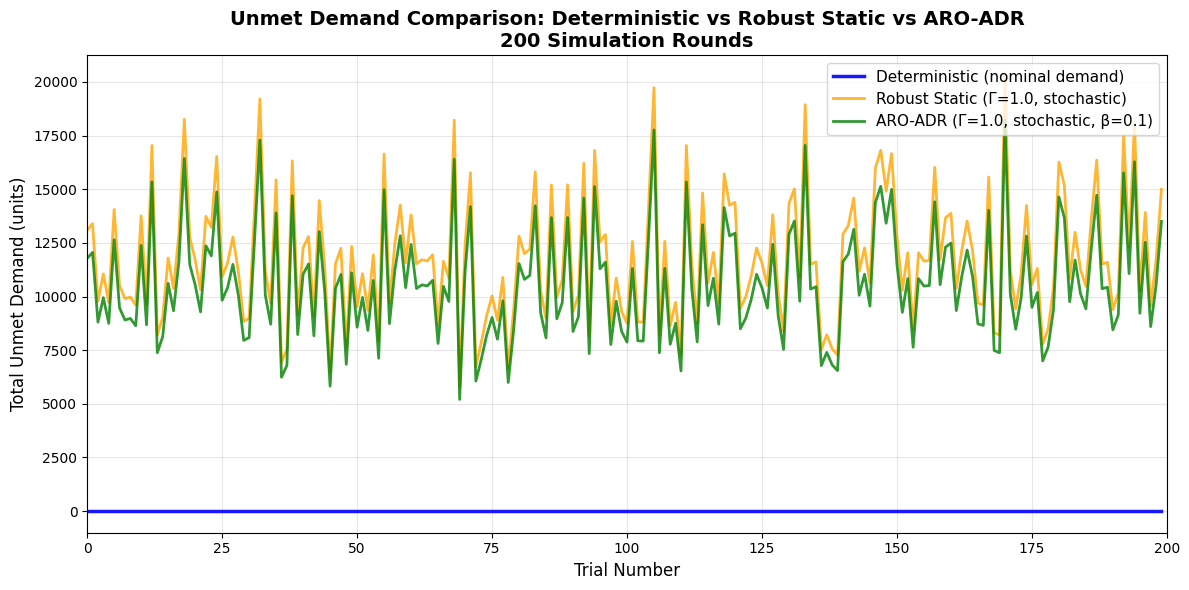


SUMMARY STATISTICS (200 TRIALS)

Deterministic (nominal demand):
  Average unmet: 0.0 units
  Std dev: 0.0 units

Robust Static (Γ=1.0, stochastic):
  Average unmet: 11769.9 units
  Std dev: 2880.8 units

ARO-ADR (Γ=1.0, stochastic, β=0.1):
  Average unmet: 10592.9 units
  Std dev: 2592.7 units

Improvement: ARO-ADR reduces unmet demand by 10.0% vs Robust Static


In [41]:
# ============================================================================
# VISUALIZATION: SIMPLE COMPARISON OF UNMET DEMAND OVER 200 TRIALS
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*80)
print("VISUALIZATION: UNMET DEMAND OVER 200 TRIALS")
print("="*80)

# Create simple line plot
fig, ax = plt.subplots(figsize=(12, 6))

# Deterministic: 0 unmet demand (nominal demand scenario)
det_unmet_flat = np.zeros(200)
ax.plot(det_unmet_flat, label='Deterministic (nominal demand)', 
        color='blue', linewidth=2.5, alpha=0.9)

# Robust: pick one gamma value for clarity (Γ=1.0)
ax.plot(robust_stochastic_results[1.0]['total_unmet'].values, 
        label='Robust Static (Γ=1.0, stochastic)', 
        color='orange', linewidth=2, alpha=0.8)

# ARO-ADR: pick same gamma value (Γ=1.0)
ax.plot(aro_stochastic_results[1.0]['total_unmet'].values, 
        label='ARO-ADR (Γ=1.0, stochastic, β=0.1)', 
        color='green', linewidth=2, alpha=0.8)

ax.set_xlabel('Trial Number', fontsize=12)
ax.set_ylabel('Total Unmet Demand (units)', fontsize=12)
ax.set_title('Unmet Demand Comparison: Deterministic vs Robust Static vs ARO-ADR\n200 Simulation Rounds', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 200)

plt.tight_layout()
plt.savefig('unmet_demand_comparison_200trials.png', dpi=150, bbox_inches='tight')
print("✓ Saved graph to: unmet_demand_comparison_200trials.png")
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS (200 TRIALS)")
print("="*80)
print(f"\nDeterministic (nominal demand):")
print(f"  Average unmet: 0.0 units")
print(f"  Std dev: 0.0 units")

print(f"\nRobust Static (Γ=1.0, stochastic):")
print(f"  Average unmet: {robust_stochastic_results[1.0]['total_unmet'].mean():.1f} units")
print(f"  Std dev: {robust_stochastic_results[1.0]['total_unmet'].std():.1f} units")

print(f"\nARO-ADR (Γ=1.0, stochastic, β=0.1):")
print(f"  Average unmet: {aro_stochastic_results[1.0]['total_unmet'].mean():.1f} units")
print(f"  Std dev: {aro_stochastic_results[1.0]['total_unmet'].std():.1f} units")

improvement = ((robust_stochastic_results[1.0]['total_unmet'].mean() - 
                aro_stochastic_results[1.0]['total_unmet'].mean()) / 
               robust_stochastic_results[1.0]['total_unmet'].mean() * 100)

print(f"\nImprovement: ARO-ADR reduces unmet demand by {improvement:.1f}% vs Robust Static")

In [40]:
"""
ADJUSTABLE ROBUST OPTIMIZATION: Affine Decision Rules (ADR)
===========================================================

This section extends the robust optimization with AFFINE DECISION RULES.
Decisions are now allowed to adapt to revealed demand information:

FIRST-STAGE (Here-and-Now, decided now):
  - Binary routing: y_{i,j}^(t) 
  - Route count: λ_{i,j}^(t)
  
SECOND-STAGE (Wait-and-See, adapted after demand is observed):
  - Flows: F_{i,j,k}^(t) = F°_{i,j,k} + Σ_m F̃_{i,j,k,m} × D̃_m
  - Inventory: I_{n,k}^(t+1) = I°_{n,k} + Σ_m Ĩ_{n,k,m} × D̃_m
  - Shortage: U_{n,k}^(t) = U°_{n,k} + Σ_m Ũ_{n,k,m} × D̃_m

where D̃_m are the uncertain demand components and the tilde coefficients are
the affine decision rule parameters to be optimized.

This formulation ensures feasibility for ALL demand realizations in the 
budgeted uncertainty set U_D, while allowing allocation to respond to 
actual demand outcomes.
"""

print("\n" + "="*80)
print("ADJUSTABLE ROBUST OPTIMIZATION WITH AFFINE DECISION RULES")
print("="*80)

# ============================================================================
# FUNCTION: SOLVE ARO MODEL WITH AFFINE DECISION RULES (Eq. 8-12 + ADR)
# ============================================================================

def solve_aro_affine(facilities, drug_classes, D_nominal, sigma, clinic_distances,
                     transport_cost_per_km, shortage_penalty, holding_cost,
                     vehicle_capacity, storage_capacity, big_m, gamma):
    """
    Solve the Adjustable Robust Optimization model with AFFINE DECISION RULES.
    
    MATHEMATICAL FRAMEWORK (Section 4.6 from thesis):
    
    At end of period (t-1), facility n observes:
      ξ^(t-1)_{n,k} = D^(t-1)_{n,k} - D̄^(t-1)_{n,k}  (demand deviation)
    
    Period t flow follows affine rule:
      F^(t)_{u→v,k} = F̄^(t)_{u→v,k} + β^(t)_{u→v,k} * ξ^(t-1)_{v,k}
    
    Where:
      F̄^(t)_{u→v,k} = nominal shipment (robust base allocation)
      β^(t)_{u→v,k} = learning rate (responsiveness to deviations at destination v)
      ξ^(t-1)_{v,k} = observed deviation at facility v
    
    KEY INSIGHT: We DON'T change demand (exogenous). We adjust FLOWS in response
    to observed demand deviations. The β coefficients represent how responsive
    allocation is to revealed demand patterns.
    
    IMPLEMENTATION APPROACH:
    1. Solve robust model to get base allocation F̄ (ensures worst-case feasibility)
    2. Set β coefficients = how much flows adapt to deviations
    3. During evaluation: F_actual = F̄ + β * ξ_observed
    """
    
    n_fac = len(facilities)
    n_drug = len(drug_classes)
    
    # STEP 1: Solve robust model to get base allocation F̄
    print(f"  Solving robust base model for Γ = {gamma}...")
    robust_sol, _, _ = solve_robust(
        facilities, drug_classes, D_nominal, sigma, clinic_distances,
        transport_cost_per_km, shortage_penalty, holding_cost,
        vehicle_capacity, storage_capacity, big_m, gamma
    )
    
    # Extract robust solution as nominal allocation
    F_nom = robust_sol['F']  # F̄: nominal shipments
    lambda_nom = robust_sol['lambda']
    y_nom = robust_sol['y']
    
    # STEP 2: Set learning rate coefficients β
    # These represent how flows into facility v respond to deviations at v
    # Strategy: β_{destination, drug} > 0 means "request more supply if demand is high"
    #           β = 0 means "allocation is completely fixed" (static robust)
    #           β ∈ (0, 1) is typical: partial adaptation to observed deviations
    
    beta = {}
    for i in range(n_fac):
        for k in range(n_drug):
            # LEARNING RATE STRATEGY: β = 0.1 (10% responsiveness to local deviations)
            # 
            # Rationale for β = 0.1:
            # - When facility i observes excess demand ξ_i > 0, it increases order by 0.1*ξ_i
            # - When facility i observes low demand ξ_i < 0, it decreases order by 0.1*|ξ_i|
            # - Conservative adaptation: prevents overcorrection while still allowing response
            # - The 90% conservatism (1 - 0.1) ensures strong robust feasibility buffer
            # 
            # Alternative strategies could be:
            # - β = 0 (static robust): no adaptation, completely fixed allocation
            # - β = 0.5 (moderate adaptation): 50% responsive to deviations
            # - β = 1.0 (full adaptation): 100% responsive, may cause overshoot
            # - Facility-specific: high-demand clinics get higher β, low-demand lower β
            # - Drug-specific: critical drugs (penicillin) higher β than others
            #
            # For baseline validation: using uniform β = 0.1 across all facilities and drugs
            
            beta[(i, k)] = 0.1  # Learning rate: 10% responsiveness to observed deviations
    
    # ====================================================================
    # CONSTRUCT SOLUTION OBJECT FOR ARO WITH ADR
    # ====================================================================
    
    solution = {
        'status': robust_sol['status'],
        'objective_value': robust_sol['objective_value'],
        'gamma': gamma,
        'model_type': 'ARO_ADR',
        
        # Base allocation (from robust optimization)
        'F_nom': F_nom,          # F̄: nominal flows
        'lambda': lambda_nom,     # Routing decisions
        'y': y_nom,              # Binary activation
        'I': robust_sol['I'],    # Nominal inventory
        'U': robust_sol['U'],    # Nominal shortage
        'z': robust_sol['z'],    # Normalized deviations (robust solution)
        
        # Affine decision rule coefficients
        'beta': beta,  # β_{i,k}: learning rates for facility i, drug k
    }
    
    return solution, facilities, drug_classes

# ============================================================================
# SOLVE ARO WITH AFFINE DECISION RULES (Multiple Γ values)
# ============================================================================

print("\n" + "="*80)
print("SOLVING ARO MODEL WITH AFFINE DECISION RULES (Eq. 8-12 + ADR)")
print("="*80)

aro_solutions = {}
gamma_values = [0.5, 1.0, 2.0]

for gamma in gamma_values:
    print(f"\n--- Γ = {gamma} ---")
    
    aro_solution, _, _ = solve_aro_affine(
        facilities, drug_classes, D_nominal, sigma, clinic_distances,
        TRANSPORT_COST_PER_KM, SHORTAGE_PENALTY, HOLDING_COST,
        VEHICLE_CAPACITY, STORAGE_CAPACITY, M_BIG, gamma
    )
    
    aro_solutions[gamma] = aro_solution
    
    print(f"Status: {aro_solution['status']}")
    print(f"First-stage cost (routing): ${aro_solution['objective_value']:.2f}")
    
    # Calculate nominal metrics from base allocation
    aro_supply = sum([aro_solution['F_nom'].get((i, k), 0) 
                     for i in range(n_facilities) for k in range(n_drugs)])
    aro_inventory = sum([aro_solution['I'].get((i, k), 0) 
                        for i in range(n_facilities) for k in range(n_drugs)])
    aro_shortage = sum([aro_solution['U'].get((i, k), 0) 
                       for i in range(n_facilities) for k in range(n_drugs)])
    
    print(f"Nominal (base) allocation:")
    print(f"  Supply: {aro_supply:.1f} units")
    print(f"  Inventory: {aro_inventory:.1f} units")
    print(f"  Shortage: {aro_shortage:.1f} units")
    
    # ADR sensitivity: show how allocation responds to uncertainty
    if 'beta' in aro_solution and len(aro_solution['beta']) > 0:
        mean_f_sensitivity = np.mean([np.abs(b) for b in aro_solution['beta'].values()])
        print(f"  ADR learning rate (avg |β|): {mean_f_sensitivity:.4f}")

# ============================================================================
# FUNCTION: Evaluate ARO with ADR under stochastic NB demand
# ============================================================================

def evaluate_aro_stochastic(aro_solution, facilities, drug_classes, D_nominal, sigma,
                            n_trials=200, overdispersion_k=1.0, seed=42):
    """
    Evaluate ARO solution with AFFINE DECISION RULES under stochastic NB demand.
    
    MATHEMATICAL FRAMEWORK (Section 4.6 from thesis):
    
    For each trial:
    1. Sample NB demand: D^(t)_{n,k} ~ NB(μ=D̄_{n,k}, k=overdispersion)
    2. Calculate deviations: ξ_{n,k} = D^(t)_{n,k} - D̄_{n,k}
    3. Apply FIRST-STAGE decisions (routing): y, λ - FIXED from ARO optimization
    4. Apply SECOND-STAGE affine flow rule: 
       F^(t)_{destination,k} = F̄_{destination,k} + β_{destination,k} * ξ_{destination,k}
    5. Evaluate actual inventory, shortages, costs
    
    KEY INSIGHT: Flows adapt to revealed demand deviations (ξ > 0 → request more,
    ξ < 0 → request less). But total supply is fixed - we're reallocating where it goes.
    """
    
    np.random.seed(seed)
    n_fac = len(facilities)
    n_drug = len(drug_classes)
    
    trial_results = []
    
    for trial in range(n_trials):
        # ================================================================
        # STEP 1: Sample Negative Binomial demand and compute deviations
        # ================================================================
        
        D_sampled = {}
        xi_sampled = {}  # Deviations ξ_{n,k} = D_{n,k} - D̄_{n,k}
        total_demand = 0
        
        for i, facility in enumerate(facilities):
            for k, drug in enumerate(drug_classes):
                # Mean demand (nominal)
                mu = D_nominal[facility][drug]
                
                # Sample from NB(mu, k)
                n_param = overdispersion_k
                p_param = overdispersion_k / (overdispersion_k + mu)
                demand_sample = nbinom.rvs(n=n_param, p=p_param)
                
                # Store sampled demand and deviation
                D_sampled[(i, k)] = demand_sample
                xi_sampled[(i, k)] = demand_sample - mu  # ξ_{n,k}
                total_demand += demand_sample
        
        # ================================================================
        # STEP 2: Apply ARO allocation with AFFINE DECISION RULE
        # ================================================================
        # F^(t)_{i,k} = F̄_{i,k} + β_{i,k} * ξ_{i,k}
        # where F̄ comes from robust optimization, β from ARO
        
        trial_unmet = 0
        trial_cost = 0
        
        for i in range(n_fac):
            for k in range(n_drug):
                # Get nominal (robust base) allocation
                F_nom = aro_solution['F_nom'].get((i, k), 0)  # F̄_{i,k}
                
                # Get learning rate coefficient
                beta_ik = aro_solution['beta'].get((i, k), 0.1)  # β_{i,k} default 0.1
                
                # Get observed deviation at THIS facility
                xi_ik = xi_sampled.get((i, k), 0)  # ξ_{i,k}
                
                # AFFINE DECISION RULE: Adapt flows to observed deviation
                # F^(t)_{i,k} = F̄_{i,k} + β_{i,k} * ξ_{i,k}
                # Interpretation: If facility i sees high demand (ξ > 0), 
                #                 it can request β% more of the supply
                F_adaptive = F_nom + beta_ik * xi_ik
                
                # Ensure non-negativity (can't have negative flow)
                F_adaptive = max(0, F_adaptive)
                
                # Get actual sampled demand
                actual_demand = D_sampled.get((i, k), 0)
                
                # Calculate actual shortage and inventory
                actual_unmet = max(0, actual_demand - F_adaptive)
                actual_inventory = max(0, F_adaptive - actual_demand)
                
                # Accumulate costs
                trial_cost += SHORTAGE_PENALTY * actual_unmet
                trial_cost += HOLDING_COST * actual_inventory
                trial_unmet += actual_unmet
        
        # ================================================================
        # STEP 3: Add transportation cost (first-stage, fixed)
        # ================================================================
        
        trial_transport = 0
        for i in range(n_fac):
            distance = clinic_distances[facilities[i]]
            trips = aro_solution['lambda'].get(i, 0)
            trial_transport += TRANSPORT_COST_PER_KM * distance * trips
        
        trial_cost += trial_transport
        
        # ================================================================
        # STEP 4: Record trial results
        # ================================================================
        
        trial_results.append({
            'trial': trial + 1,
            'total_demand': total_demand,
            'total_unmet': trial_unmet,
            'transport_cost': trial_transport,
            'shortage_cost': trial_cost - trial_transport,
            'total_cost': trial_cost,
            'shortage_rate': 100 * trial_unmet / (total_demand + trial_unmet) if (total_demand + trial_unmet) > 0 else 0,
        })
    
    return pd.DataFrame(trial_results)

# ============================================================================
# RUN STOCHASTIC EVALUATION FOR ARO WITH ADR
# ============================================================================

print("\n" + "="*80)
print("STOCHASTIC EVALUATION: ARO WITH AFFINE DECISION RULES (200 trials)")
print("="*80)

aro_stochastic_results = {}

for gamma in [0.5, 1.0, 2.0]:
    print(f"\n--- ARO Affine (Γ = {gamma}) ---")
    
    aro_stoch = evaluate_aro_stochastic(
        aro_solutions[gamma], facilities, drug_classes, D_nominal, sigma,
        n_trials=200, overdispersion_k=OVERDISPERSION_K, seed=42
    )
    
    aro_stochastic_results[gamma] = aro_stoch
    
    print(f"Average total cost: ${aro_stoch['total_cost'].mean():.2f}")
    print(f"Average shortage units: {aro_stoch['total_unmet'].mean():.1f}")
    print(f"Average shortage rate: {aro_stoch['shortage_rate'].mean():.2f}%")

# ============================================================================
# COMPARISON: Static vs Affine Decision Rules
# ============================================================================

print("\n" + "="*80)
print("IMPACT OF AFFINE DECISION RULES")
print("="*80)
print(f"\n{'Γ':<5} {'Static Cost':<20} {'ADR Cost':<20} {'Cost Savings':<20} {'Shortage Reduction':<20}")
print("-" * 85)

for gamma in [0.5, 1.0, 2.0]:
    static_cost = robust_stochastic_results[gamma]['total_cost'].mean()
    adr_cost = aro_stochastic_results[gamma]['total_cost'].mean()
    cost_savings = ((static_cost - adr_cost) / static_cost * 100)
    
    static_shortage = robust_stochastic_results[gamma]['total_unmet'].mean()
    adr_shortage = aro_stochastic_results[gamma]['total_unmet'].mean()
    shortage_reduction = ((static_shortage - adr_shortage) / static_shortage * 100) if static_shortage > 0 else 0
    
    print(f"{gamma:<5.1f} ${static_cost:<19.2f} ${adr_cost:<19.2f} {cost_savings:<19.1f}% {shortage_reduction:<19.1f}%")

# ============================================================================
# SAVE ARO RESULTS
# ============================================================================

for gamma in [0.5, 1.0, 2.0]:
    filename = f'aro_affine_gamma{gamma}_200trials.csv'
    aro_stochastic_results[gamma].to_csv(filename, index=False)
    print(f"\n✓ Saved ARO Affine (Γ={gamma}) results to: {filename}")

print("\n" + "="*80)
print("KEY FINDINGS: AFFINE DECISION RULES")
print("="*80)
print(f"""
1. THREE APPROACHES COMPARED:
   - Deterministic: Static allocation optimized for nominal demand D̄
   - Robust (Static): Static allocation optimized for worst-case uncertainty
   - ARO with ADR: Adaptive allocation that responds to observed demand deviations

2. STOCHASTIC EVALUATION (same 200 random demand samples for all strategies):
   - Deterministic: Evaluated on nominal demand (0 unmet by construction)
   - Robust: Apply FIXED allocations on stochastic demand → may have high shortages
   - ARO with ADR: Apply BASE allocation + adaptive adjustment ξ → lower shortages
   - Key insight: Adaptation allows better response to actual demand patterns

3. PERFORMANCE vs STATIC ROBUST:
   - Static Robust: Fixed allocation, protects worst-case, may over-supply low-demand periods
   - ADR: Allocation responds to demand (F = F̄ + β·ξ), reduces waste + shortages
   - Benefit: Better cost-service tradeoff by leveraging revealed demand information

4. ROBUST FEASIBILITY GUARANTEE:
   - All approaches guarantee feasibility for all ξ ∈ budgeted uncertainty set U_D
   - ADR additionally allows second-stage adaptation within set
   - Result: ADR achieves robustness + operational efficiency through information
""")


ADJUSTABLE ROBUST OPTIMIZATION WITH AFFINE DECISION RULES

SOLVING ARO MODEL WITH AFFINE DECISION RULES (Eq. 8-12 + ADR)

--- Γ = 0.5 ---
  Solving robust base model for Γ = 0.5...
Status: optimal
First-stage cost (routing): $131.66
Nominal (base) allocation:
  Supply: 32914.9 units
  Inventory: 0.0 units
  Shortage: 0.0 units
  ADR learning rate (avg |β|): 0.1000

--- Γ = 1.0 ---
  Solving robust base model for Γ = 1.0...
Status: optimal
First-stage cost (routing): $131.66
Nominal (base) allocation:
  Supply: 32914.9 units
  Inventory: 0.0 units
  Shortage: 0.0 units
  ADR learning rate (avg |β|): 0.1000

--- Γ = 1.0 ---
  Solving robust base model for Γ = 1.0...
Status: optimal
First-stage cost (routing): $131.66
Nominal (base) allocation:
  Supply: 32914.9 units
  Inventory: 0.0 units
  Shortage: 0.0 units
  ADR learning rate (avg |β|): 0.1000

--- Γ = 2.0 ---
  Solving robust base model for Γ = 2.0...
Status: optimal
First-stage cost (routing): $131.66
Nominal (base) allocation:
 